Visualization, summer term 2024 \
\
Problem sheet 04 

Submission by: 

Engel, Laurenz (21962216) \
Hesenkamp, Dennis (16442976) \
Multhaup, Justus (21963889)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio


# Exercise 4.1

## 1) Evolution of the population age distribution over time

In [2]:
df = pd.read_csv("population_us.csv")
# first summarize over sex
df = df.groupby(["year", "age"])["people"].sum().reset_index()
df.head()

,year,age,people
0,1850,0,2934165
1,1850,5,2770735
2,1850,10,2476213
3,1850,15,2187752
4,1850,20,2021122


In [3]:
# extract unique years and ages
years = df["year"].unique()
ages = df["age"].unique()


# first method: plot as 2d histogram
# create 2d histogram
h = np.zeros((years.shape[0], ages.shape[0]))
for i, year in enumerate(years):
    for j, age in enumerate(ages):
        people = df[(df["year"] == year) & (df["age"] == age)]["people"].values[0]
        h[i, j] = people
# normalize h by total number of people in specific year
for i in range(years.shape[0]):
    h[i,:] = h[i,:] / h[i,:].sum()

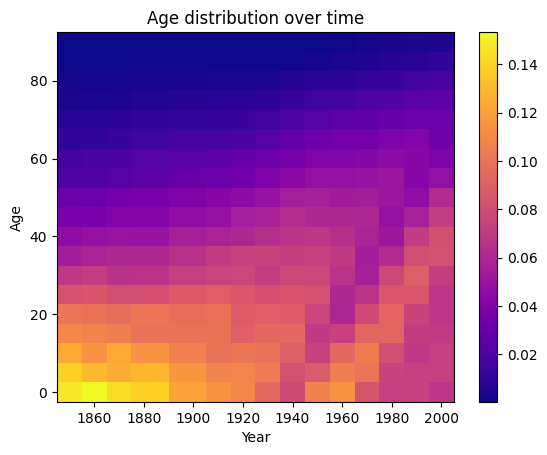

In [4]:
cmap = plt.colormaps["plasma"]
#cmap = cmap.with_extremes(bad=cmap(0))

plt.figure()
plt.title("Age distribution over time")
plt.xlabel("Year")
plt.ylabel("Age")
plt.pcolormesh(years, ages, h.T, rasterized=True, cmap=cmap)
plt.colorbar()
plt.show()

In [7]:
h.shape

(15, 19)

In [5]:
# alternative: 3d plot
yrs, ags = np.meshgrid(years, ages)
# Create a surface plot
surface = go.Surface(x=yrs, y=ags, z=h.T)

# Create a figure object
fig = go.Figure(data=[surface])

# Set layout options
fig.update_layout(
    title='Age distribution over the years',
    scene=dict(
        xaxis=dict(title='Year'),
        yaxis=dict(title='Age'),
        zaxis=dict(title='Percentage'),
    )
)

# Show the plot
fig.show()
pio.write_image(fig, 'age_distribution_3D.pdf', format='pdf')




In [7]:
# second method: plot evolution of mean and standard deviation of age

# plot mean and standard deviation
# compute mean and standard variation of y in each bin
def compute_mean_and_standard(df_in):
    df = df_in.copy()
    # compute product of age and people to calculate mean
    df["age_times_people"] = df["age"] * df["people"]
    # aggregate people and age * people per year
    df = df.groupby("year").agg({"people": "sum",
                                 "age_times_people": "sum"}).reset_index().rename({"people": "sum_people"}, axis=1)
    # calculate mean age
    df["mean_age"] = df["age_times_people"] / df["sum_people"]
    # join mean age onto original dataframe
    df = df_in.merge(df[["year", "mean_age", "sum_people"]],
                     how="inner")
    # calculate variance terms
    df["temp"] = (df["age"] - df["mean_age"])**2 * df["people"] / df["sum_people"]
    # sum variance terms per year
    df_stds = df.groupby("year").agg({"temp" :
                                      "sum"}).reset_index().rename({"temp": "std_age"}, axis=1)
    # compute standard deviation
    df_stds["std_age"] = np.sqrt(df_stds["std_age"])
    df_final = df_stds.merge(df[["year", "mean_age"]], on="year")
    return df_final


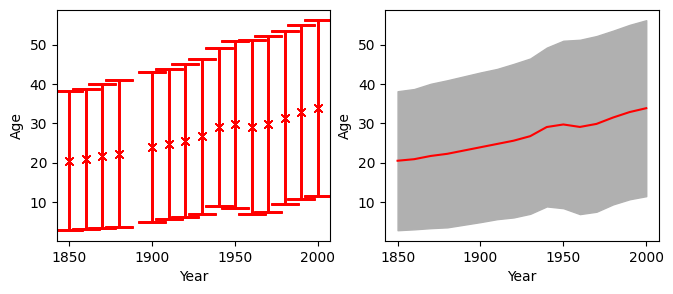

In [8]:
df_final = compute_mean_and_standard(df)
# plot
fig=plt.figure(figsize=(12,3))
fig.add_subplot(1,3,1)
plt.xlabel("Year")
plt.ylabel("Age")
plt.errorbar(df_final["year"],df_final["mean_age"], yerr=df_final["std_age"],capsize=10,c="r",marker="x",lw=0,elinewidth=1)

# alternative visualization: since we have a time-continuous process, could show mean as curve, stdev as area
fig.add_subplot(1,3,2)
plt.xlabel("Year")
plt.ylabel("Age")
plt.fill_between(df_final["year"],
                 df_final["mean_age"]- df_final["std_age"], 
                 df_final["mean_age"]+ df_final["std_age"],color="#b0b0b0",zorder=-1)
plt.plot(df_final["year"],df_final["mean_age"],c="r",marker="")

## 2) Deviations between male and female distribtuion

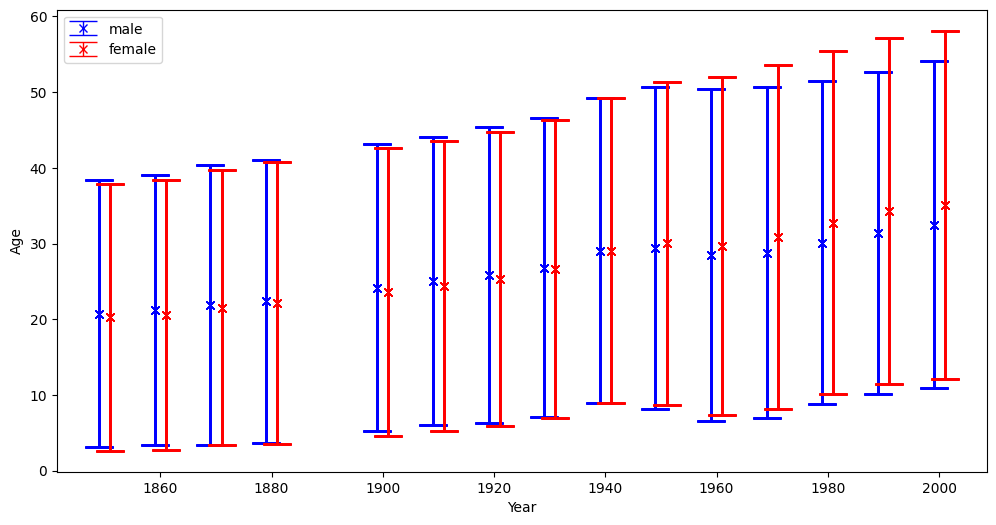

In [9]:
# use the mean and std deviation method to compare
df = pd.read_csv("population_us.csv")
df_male = df[df["sex"] == 1]
df_female = df[df["sex"] == 2]
df_male = compute_mean_and_standard(df_male)
df_female = compute_mean_and_standard(df_female)

# plot
fig=plt.figure(figsize=(12,6))
plt.xlabel("Year")
plt.ylabel("Age")
plt.errorbar(df_male["year"]-1,df_male["mean_age"], 
             yerr=df_male["std_age"],capsize=10,c="b",marker="x",lw=0,elinewidth=1, label="male")
plt.errorbar(df_female["year"]+1,df_female["mean_age"], 
             yerr=df_female["std_age"],capsize=10,c="r",marker="x",lw=0,elinewidth=1, label="female")
plt.legend()
plt.show()

# Exercise 4.2

## 1.) Triangulation of cube

In [10]:
points=np.array([[0,0,0],[0,1,0],[0,1,1],[0,0,1],
         [1,0,0],[1,1,0],[1,1,1],[1,0,1]],dtype=np.double)
# triangulation is simple here
# we just need to divide each surface by its diagonal
# this yields a total of 12 triangles
triangles = np.array([[0, 1, 2], [0, 2, 3],
                      [4, 5, 6], [4, 6, 7],
                      [0, 3, 7], [0, 4, 7],
                      [1, 2, 6], [1, 5, 6],
                      [2, 3, 7], [2, 6, 7],
                      [0, 1, 4], [0, 4, 5]])


In [11]:
import plotly.graph_objects as go

# take function from lecture
def plotMeshPlotly(points,triangles):
    tri_points=points[triangles]
    Xe = []
    Ye = []
    Ze = []
    for T in tri_points:
        Xe.extend([T[k%3][0] for k in range(4)]+[ None])
        Ye.extend([T[k%3][1] for k in range(4)]+[ None])
        Ze.extend([T[k%3][2] for k in range(4)]+[ None])
       
    #define the trace for triangle sides
    lines = go.Scatter3d(
                       x=Xe,
                       y=Ye,
                       z=Ze,
                       mode='lines',
                       name='',
                       line=dict(color= 'rgb(70,70,70)', width=2)) 

    mesh=go.Mesh3d(x=points[:,0],y=points[:,1],z=points[:,2],i=triangles[:,0],j=triangles[:,1],k=triangles[:,2])
    
    fig = go.Figure(data=[mesh,lines],layout={"height":500,"scene":{"aspectratio":{"x":1,"y":1,"z":1}}})
    return fig
fig = plotMeshPlotly(points,triangles)
fig.show()
pio.write_image(fig, 'cube_triangulation.pdf', format='pdf')


## 2.) Triangulation of unit disk

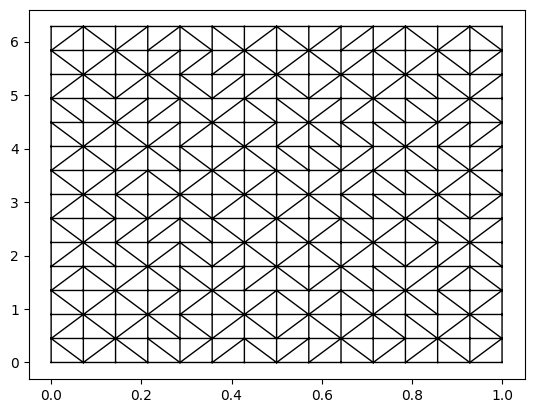

In [13]:
# define rectangle
r = np.linspace(0,1, 15)
phi = np.linspace(0,2 * np.pi, 15)
# define grid
r, phi = np.meshgrid(r, phi)
# compute triangulation
tri_disk = matplotlib.tri.Triangulation(np.ravel(r), np.ravel(phi))

# sanity check: visualize this triangulation
ax = plt.axes()
ax.triplot(tri_disk,color="k",lw=1)
plt.show()

In [14]:
# define homeomorphism between rectangle and disk

x = np.ravel(r * np.cos(phi))
y = np.ravel(r * np.sin(phi))
z = np.zeros_like(x)
points_disk = np.stack([x, y, z], axis=1)

In [15]:
fig = plotMeshPlotly(points_disk,tri_disk.triangles)
fig.show()
pio.write_image(fig, 'disk_triangulation.pdf', format='pdf')

## 3.) Triangulation of cylinder

In [16]:
# the cylinder is composed of the Mantelfläche and the two disks that form the Stirnflächen


# Mantelfläche
# define rectangle
z = np.linspace(0,1, 15)
phi = np.linspace(0,2 * np.pi, 15)
# define grid
z, phi = np.meshgrid(z, phi)
# compute triangulation
tri_mantel = matplotlib.tri.Triangulation(np.ravel(z), np.ravel(phi))
# define mapping to cylinder
x = np.ravel(np.cos(phi))
y = np.ravel(np.sin(phi))
points_mantel = np.stack([x, y, np.ravel(z)], axis=1)

# Stirnflächen
points_bottom = points_disk.copy()
points_top = points_disk.copy()
# adjust z value of upper disk
points_top[:, 2] = points_top[:, 2] + 1

# combine all points in one array
points_cyl = np.concatenate([points_bottom, points_mantel, points_top])
triangles_cyl = np.concatenate([tri_disk.triangles, tri_mantel.triangles + len(points_bottom), tri_disk.triangles + len(points_bottom) + len(points_mantel)])

fig = plotMeshPlotly(points_cyl, triangles_cyl)
fig.show()
pio.write_image(fig, 'cylinder_triangulation.pdf', format='pdf')
